In [65]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import MinMaxScaler

import string

# Little utility to clean NaNs, inifinity from dataframe
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) 
# that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Dataset
Load dataset, only some rows taken every 80 occurrences in order to look only at the same game reviews

In [66]:
def logic(index):
    if index % 80 == 0:
       return False
    return True

In [67]:
# Load Dataset
df = pd.read_csv("steam_reviews.csv",skiprows= lambda x: logic(x))
#df = pd.read_csv("steam_reviews.csv")
print("Num of rows loaded: " + str(len(df)))

Num of rows loaded: 271842


In [68]:
df.head()

,Unnamed: 0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,79,292030,The Witcher 3: Wild Hunt,85165253,english,After playing through the base game twice and ...,1611349999,1611349999,True,0,...,False,False,False,76561198070919036,227,12,11462.0,1867.0,11462.0,1.611350e+09
1,159,292030,The Witcher 3: Wild Hunt,85151673,russian,1. Сюжет отличный - 5\n2. Игровой процесс - 3\...,1611332857,1611332857,True,0,...,True,False,False,76561198212211092,6,1,6489.0,6489.0,6105.0,1.611356e+09
2,239,292030,The Witcher 3: Wild Hunt,85136322,schinese,是男人就来玩巫师,1611312755,1611312755,True,0,...,True,False,False,76561198451556987,44,3,6168.0,335.0,6058.0,1.611319e+09
3,319,292030,The Witcher 3: Wild Hunt,85122630,schinese,剧情很赞 画面绚丽 仿佛就在那片大陆上 持剑冒险,1611287819,1611287819,True,0,...,True,False,False,76561198174834851,33,3,1801.0,489.0,1801.0,1.611225e+09
4,399,292030,The Witcher 3: Wild Hunt,85103793,polish,Zajebista gra polecam wszystkim .\nocena 11/10,1611256730,1611256730,True,0,...,True,False,False,76561198347082913,54,5,7980.0,5562.0,7980.0,1.611127e+09


In [69]:
# Output all columns name
list(df.columns)

['Unnamed: 0',
 'app_id',
 'app_name',
 'review_id',
 'language',
 'review',
 'timestamp_created',
 'timestamp_updated',
 'recommended',
 'votes_helpful',
 'votes_funny',
 'weighted_vote_score',
 'comment_count',
 'steam_purchase',
 'received_for_free',
 'written_during_early_access',
 'author.steamid',
 'author.num_games_owned',
 'author.num_reviews',
 'author.playtime_forever',
 'author.playtime_last_two_weeks',
 'author.playtime_at_review',
 'author.last_played']

# K means without any processing
K means is computed by ruling out all non-numeric columns including booleans and strings.

It is possibile to choose between:
* all columns with numeric values
* meaningful numeric values (ids excluded)

In [70]:
all_columns_with_numbers = ['app_id','review_id','timestamp_created','timestamp_updated','votes_helpful','votes_funny','weighted_vote_score',
          'comment_count','author.num_games_owned','author.steamid','author.num_reviews','author.playtime_forever',
          'author.playtime_last_two_weeks','author.playtime_at_review']
columns = ['app_id','timestamp_created','timestamp_updated','votes_helpful','votes_funny','weighted_vote_score',
          'comment_count','author.num_games_owned','author.num_reviews','author.playtime_forever',
          'author.playtime_last_two_weeks','author.playtime_at_review']
columns_2 = ['timestamp_created','timestamp_updated','votes_helpful','votes_funny','weighted_vote_score',
          'comment_count','author.num_games_owned','author.num_reviews','author.playtime_forever',
          'author.playtime_last_two_weeks','author.playtime_at_review']
columns_3 = ['votes_helpful','votes_funny','weighted_vote_score',
          'comment_count','author.num_games_owned','author.num_reviews','author.playtime_forever',
          'author.playtime_last_two_weeks','author.playtime_at_review']
df1 =  df.loc[:, all_columns_with_numbers]
df1.head()

,app_id,review_id,timestamp_created,timestamp_updated,votes_helpful,votes_funny,weighted_vote_score,comment_count,author.num_games_owned,author.steamid,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review
0,292030,85165253,1611349999,1611349999,0,0,0.0,0,227,76561198070919036,12,11462.0,1867.0,11462.0
1,292030,85151673,1611332857,1611332857,0,0,0.0,0,6,76561198212211092,1,6489.0,6489.0,6105.0
2,292030,85136322,1611312755,1611312755,0,0,0.0,0,44,76561198451556987,3,6168.0,335.0,6058.0
3,292030,85122630,1611287819,1611287819,0,0,0.0,0,33,76561198174834851,3,1801.0,489.0,1801.0
4,292030,85103793,1611256730,1611256730,0,0,0.0,0,54,76561198347082913,5,7980.0,5562.0,7980.0


In [71]:
# Cleanup
df1 = clean_dataset(df1)
df1.head()

,app_id,review_id,timestamp_created,timestamp_updated,votes_helpful,votes_funny,weighted_vote_score,comment_count,author.num_games_owned,author.steamid,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review
0,292030.0,85165253.0,1.611350e+09,1.611350e+09,0.0,0.0,0.0,0.0,227.0,7.656120e+16,12.0,11462.0,1867.0,11462.0
1,292030.0,85151673.0,1.611333e+09,1.611333e+09,0.0,0.0,0.0,0.0,6.0,7.656120e+16,1.0,6489.0,6489.0,6105.0
2,292030.0,85136322.0,1.611313e+09,1.611313e+09,0.0,0.0,0.0,0.0,44.0,7.656120e+16,3.0,6168.0,335.0,6058.0
3,292030.0,85122630.0,1.611288e+09,1.611288e+09,0.0,0.0,0.0,0.0,33.0,7.656120e+16,3.0,1801.0,489.0,1801.0
4,292030.0,85103793.0,1.611257e+09,1.611257e+09,0.0,0.0,0.0,0.0,54.0,7.656120e+16,5.0,7980.0,5562.0,7980.0


In [72]:
def elbow(df): # Elbow method for best k
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}

    K = range(1, 10)

    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(df)
        kmeanModel.fit(df)

        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / df.shape[0])
        inertias.append(kmeanModel.inertia_)

        mapping1[k] = sum(np.min(cdist(df, kmeanModel.cluster_centers_,
                                       'euclidean'), axis=1)) / df.shape[0]
        mapping2[k] = kmeanModel.inertia_

        print("Iter "+str(k)+" of "+str(max(K))+" done...")
    
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()
    
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()


Iter 1 of 9 done...
Iter 2 of 9 done...
Iter 3 of 9 done...
Iter 4 of 9 done...
Iter 5 of 9 done...
Iter 6 of 9 done...
Iter 7 of 9 done...
Iter 8 of 9 done...
Iter 9 of 9 done...


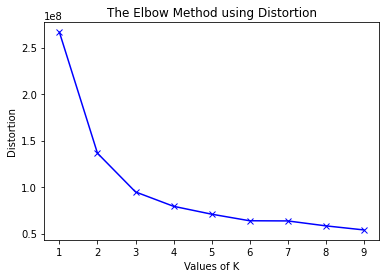

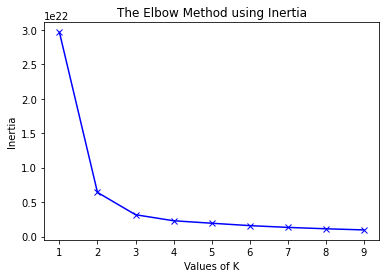

CPU times: user 3min 45s, sys: 5.76 s, total: 3min 50s
Wall time: 30.2 s


In [73]:
%%time
elbow(df1)

In [74]:
# Is 3 the optimal? [Choose optimal]
optimal = 3
kmeans = KMeans(n_clusters=optimal).fit(df1)

In [75]:
# Optimal k-means
labels = pd.DataFrame(kmeans.labels_) #This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeled_df = pd.concat((df1,labels),axis=1)
labeled_df = labeled_df.rename({0:'labels'},axis=1)
labeled_df.head()

,app_id,review_id,timestamp_created,timestamp_updated,votes_helpful,votes_funny,weighted_vote_score,comment_count,author.num_games_owned,author.steamid,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,labels
0,292030.0,85165253.0,1.611350e+09,1.611350e+09,0.0,0.0,0.0,0.0,227.0,7.656120e+16,12.0,11462.0,1867.0,11462.0,0.0
1,292030.0,85151673.0,1.611333e+09,1.611333e+09,0.0,0.0,0.0,0.0,6.0,7.656120e+16,1.0,6489.0,6489.0,6105.0,2.0
2,292030.0,85136322.0,1.611313e+09,1.611313e+09,0.0,0.0,0.0,0.0,44.0,7.656120e+16,3.0,6168.0,335.0,6058.0,2.0
3,292030.0,85122630.0,1.611288e+09,1.611288e+09,0.0,0.0,0.0,0.0,33.0,7.656120e+16,3.0,1801.0,489.0,1801.0,0.0
4,292030.0,85103793.0,1.611257e+09,1.611257e+09,0.0,0.0,0.0,0.0,54.0,7.656120e+16,5.0,7980.0,5562.0,7980.0,2.0


# Display data by choosing only two axes (at random)
By just changing the "perspective" without any other changes

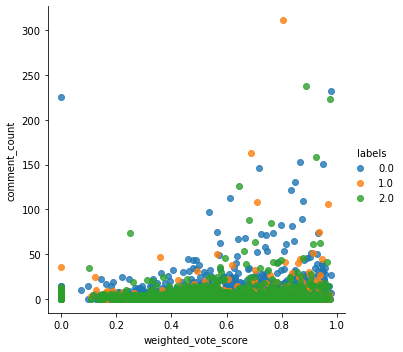

In [76]:
# Visual
sns.lmplot(x='weighted_vote_score',y='comment_count',data=labeled_df,hue='labels',fit_reg=False)

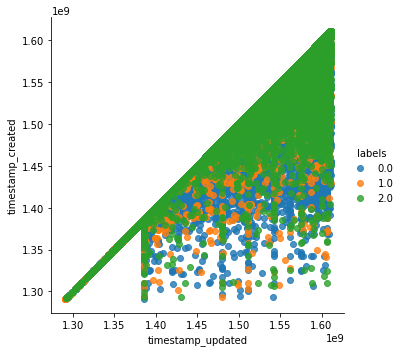

In [77]:
# Visual according to PCA
sns.lmplot(x='timestamp_updated',y='timestamp_created',data=labeled_df,hue='labels',fit_reg=False)

## PCA with pandas utils (default mean normalization)
To display data, we compute PCA with sklearn library and panda utils. 
It is possible to choose between mean normalization and min-max normalization

In [78]:
### PCA ###

# We have to exclude some columns avoiding strange behaviours, but the final result won't change
df1_ = df1[columns_2]

df_normalized=(df1_ - df1_.mean()) / df1_.std() # mean normalization
#df_normalized=(df1_-df1_.min())/(df1_.max()-df1_.min()) # min-max normalization



pca = PCA(n_components=2)

pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
    columns=['PC%s' % _ for _ in range(0,2)],
    index=df1_.columns)
print(loadings)

                                     PC0       PC1
timestamp_created              -0.572712 -0.223922
timestamp_updated              -0.574644 -0.198581
votes_helpful                   0.127002  0.105537
votes_funny                     0.009270  0.008237
weighted_vote_score             0.256691  0.149466
comment_count                   0.137185  0.115482
author.num_games_owned          0.270676  0.051833
author.num_reviews              0.175125  0.003239
author.playtime_forever        -0.187763  0.636354
author.playtime_last_two_weeks -0.229387  0.320668
author.playtime_at_review      -0.221478  0.594197


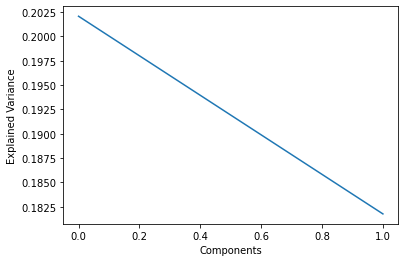

In [79]:
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

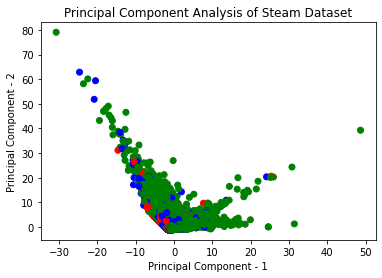

In [80]:
## First method PCA

reduced = pca.transform(df_normalized)
reduced_df = pd.DataFrame(data = reduced
             , columns = ['principal component 1', 'principal component 2'])

labeled__df = pd.concat((reduced_df,labels),axis=1)
labeled__df = labeled__df.rename({0:'labels'},axis=1)
labeled__df['color'] = labeled__df.apply (lambda row:  'r' if row['labels'] == 1 else ('g' if row['labels'] == 0 else 'b') , axis=1)
plt.xlabel('Principal Component - 1')
plt.ylabel('Principal Component - 2')
plt.title("Principal Component Analysis of Steam Dataset")
        
plt.scatter(labeled__df['principal component 1']
               , labeled__df['principal component 2'], c = labeled__df['color'])
plt.show()

## PCA with sklearn min max
Same as earlier, but this time with sklearn minmax scaler, just in case there is some difference (and per column scale)

In [81]:
#Another scaling
scaler = MinMaxScaler()
df2 = scaler.fit_transform(df1[all_columns_with_numbers])

In [82]:
pca_ = PCA(n_components = 2)
pca_.fit(df2)
reduced = pca_.transform(df2)
print(reduced)

[[-0.33021465 -0.04871924]
 [-0.38911371 -0.0565398 ]
 [-0.4805399  -0.07122496]
 ...
 [-0.0338344   0.44150605]
 [-0.01629132  0.38785036]
 [-0.12471295 -0.05787904]]


In [83]:
reduced_df = pd.DataFrame(data = reduced
             , columns = ['principal component 1', 'principal component 2'])
reduced_df.head()

,principal component 1,principal component 2
0,-0.330215,-0.048719
1,-0.389114,-0.056540
2,-0.480540,-0.071225
3,-0.370460,-0.055172
4,-0.441635,-0.064614


In [84]:
print('Explained variation per principal component: {}'.format(pca_.explained_variance_ratio_))

Explained variation per principal component: [0.51805162 0.19204645]


In [85]:
labeled__df = pd.concat((reduced_df,labels),axis=1)
labeled__df = labeled__df.rename({0:'labels'},axis=1)
labeled__df.tail()

,principal component 1,principal component 2,labels
271486,-0.026083,0.497422,0
271487,-0.040052,0.441644,0
271488,-0.033834,0.441506,0
271489,-0.016291,0.387850,0
271490,-0.124713,-0.057879,0


In [86]:
labeled__df['color'] = labeled__df.apply (lambda row:  'r' if row['labels'] == 1 else ('g' if row['labels'] == 0 else 'b') , axis=1)

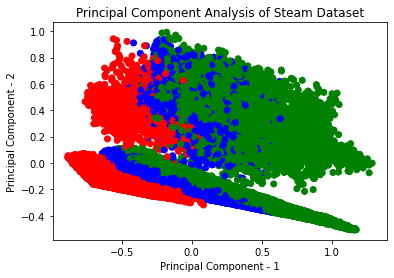

In [87]:
plt.xlabel('Principal Component - 1')
plt.ylabel('Principal Component - 2')
plt.title("Principal Component Analysis of Steam Dataset")
        
plt.scatter(labeled__df['principal component 1']
               , labeled__df['principal component 2'], c = labeled__df['color'])
plt.show()

# Preprocessing
Now it is time to really go deep into our datset

In [88]:
# New imports 
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

In [89]:
columns = ['app_name','language','review']

In [90]:
# Take this data for tfidf
df_target = df.loc[:, columns]
df_target.head()

,app_name,language,review
0,The Witcher 3: Wild Hunt,english,After playing through the base game twice and ...
1,The Witcher 3: Wild Hunt,russian,1. Сюжет отличный - 5\n2. Игровой процесс - 3\...
2,The Witcher 3: Wild Hunt,schinese,是男人就来玩巫师
3,The Witcher 3: Wild Hunt,schinese,剧情很赞 画面绚丽 仿佛就在那片大陆上 持剑冒险
4,The Witcher 3: Wild Hunt,polish,Zajebista gra polecam wszystkim .\nocena 11/10


In [91]:
# We no longer need text columns 
df = df.drop(columns=['review'])
df.head()

,Unnamed: 0,app_id,app_name,review_id,language,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,79,292030,The Witcher 3: Wild Hunt,85165253,english,1611349999,1611349999,True,0,0,...,False,False,False,76561198070919036,227,12,11462.0,1867.0,11462.0,1.611350e+09
1,159,292030,The Witcher 3: Wild Hunt,85151673,russian,1611332857,1611332857,True,0,0,...,True,False,False,76561198212211092,6,1,6489.0,6489.0,6105.0,1.611356e+09
2,239,292030,The Witcher 3: Wild Hunt,85136322,schinese,1611312755,1611312755,True,0,0,...,True,False,False,76561198451556987,44,3,6168.0,335.0,6058.0,1.611319e+09
3,319,292030,The Witcher 3: Wild Hunt,85122630,schinese,1611287819,1611287819,True,0,0,...,True,False,False,76561198174834851,33,3,1801.0,489.0,1801.0,1.611225e+09
4,399,292030,The Witcher 3: Wild Hunt,85103793,polish,1611256730,1611256730,True,0,0,...,True,False,False,76561198347082913,54,5,7980.0,5562.0,7980.0,1.611127e+09


In [92]:
df_target.head(20)

,app_name,language,review
0,The Witcher 3: Wild Hunt,english,After playing through the base game twice and ...
1,The Witcher 3: Wild Hunt,russian,1. Сюжет отличный - 5\n2. Игровой процесс - 3\...
2,The Witcher 3: Wild Hunt,schinese,是男人就来玩巫师
3,The Witcher 3: Wild Hunt,schinese,剧情很赞 画面绚丽 仿佛就在那片大陆上 持剑冒险
4,The Witcher 3: Wild Hunt,polish,Zajebista gra polecam wszystkim .\nocena 11/10
5,The Witcher 3: Wild Hunt,russian,ШЕДЕВР
6,The Witcher 3: Wild Hunt,english,good games
7,The Witcher 3: Wild Hunt,english,Awesome game
8,The Witcher 3: Wild Hunt,turkish,Oyun gayet güzel grafikleri olsun hikayenin ak...
9,The Witcher 3: Wild Hunt,schinese,巫师3永远滴神


# TF-IDF
Build TF-IDF index in order to make text eligiable for k-means

In [93]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [94]:
# Should we inlcude title in our analysis?
include_title = False

In [95]:
# some heavy preprocess
i = 0 
def process_row(row):
    global i 
    global include_title
    print("Tfidf Progress: "+str("{:.5f}".format(i/(len(df_target)-1) *100)) + "%",end="\r")
    i += 1
    
    language = row['language']
    reuslt = None
    if(include_title):
        result = (str(row['review']) + " " + str(row['app_name'])).replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
    else:
        result = (str(row['review'])).replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
    result = result.replace(',', '')          # Removes commas
    result = result.rstrip('\n')              # Removes line breaks
    result = result.casefold()                # Makes all letters lowercase

    result = re.sub('\W_',' ', result)        # removes specials characters and leaves only words
    result = re.sub("\S*\d\S*"," ", result)   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
    result = re.sub("\S*@\S*\s?"," ", result) # removes emails and mentions (words with @)
    result = re.sub(r'http\S+', '', result)   # removes URLs with http
    result = re.sub(r'www\S+', '', result)    # removes URLs with www
    
    result = re.sub(r"\s+(.)\1+\b", "",result)               # remove spammed chars
    result = ''.join([i for i in result if not i.isdigit()]) # remove numbers
    result = re.sub(r'[^\w\s]','',result)                    # remove punctuation
   

    listOfTokens = word_tokenize(result)
    twoLetterWord = twoLetters(listOfTokens)


    try: 
        # Not all languages are supported 
        # We remove stopwords and stem only with supported languages
        stopwords = nltk.corpus.stopwords.words(language)
        stopwords.append("game")
        
        param_stemmer = SnowballStemmer(language)
        listOfTokens = applyStemming(listOfTokens, param_stemmer)
        listOfTokens = removeWords(listOfTokens, stopwords) 
    finally:
        # Output the tokens
        listOfTokens = list(filter(lambda item: len(item) < 25,listOfTokens))   # other spam filter
        listOfTokens = removeWords(listOfTokens, ["game","gam","igr",
                                                  "jogo","juego","you","jogao",
                                                 "good","fun","play","great"]) # some game translations (en,en,ru,sp,ch,pt)
        
        result   = " ".join(listOfTokens)
        result = unidecode(result)
        result = re.sub(r'[^\x00-\x7F]+','', result)    # remove non ascii

        return result

# Heavy Review and App Name preprocess
* normalizing
* stemming
* tokenizing

Option to keep english only records, in order to have some coherence between data, but it is just an empirical hypotesis

In [96]:
english_only = False

In [97]:
if english_only:
    len_ = len(df_target)
    df_target = df_target[df_target.language == 'english']
    df_target.head()
    print("Length before filtering " + str(len_) + " Length after filtering "+ str(len(df_target)))

In [98]:
%%time
df_target['tokens'] = df_target.apply(lambda row: process_row(row),axis=1)

CPU times: user 3min 58s, sys: 16 s, total: 4min 14s
Wall time: 3min 57s


In [99]:
df_target.head(20)

,app_name,language,review,tokens
0,The Witcher 3: Wild Hunt,english,After playing through the base game twice and ...,base twice finish dlcs write review confid nev...
1,The Witcher 3: Wild Hunt,russian,1. Сюжет отличный - 5\n2. Игровой процесс - 3\...,siuzhet otlichn igrov protsess ekonomik muzyk ...
2,The Witcher 3: Wild Hunt,schinese,是男人就来玩巫师,Shi Nan Ren Jiu Lai Wan Wu Shi
3,The Witcher 3: Wild Hunt,schinese,剧情很赞 画面绚丽 仿佛就在那片大陆上 持剑冒险,Ju Qing Hen Zan Hua Mian Xuan Li Fang Fo Jiu...
4,The Witcher 3: Wild Hunt,polish,Zajebista gra polecam wszystkim .\nocena 11/10,zajebista gra polecam wszystkim ocena
5,The Witcher 3: Wild Hunt,russian,ШЕДЕВР,shedevr
6,The Witcher 3: Wild Hunt,english,good games,
7,The Witcher 3: Wild Hunt,english,Awesome game,awesom
8,The Witcher 3: Wild Hunt,turkish,Oyun gayet güzel grafikleri olsun hikayenin ak...,oyun gayet guzel grafikleri olsun hikayenin ak...
9,The Witcher 3: Wild Hunt,schinese,巫师3永远滴神,


In [100]:
%%time
# tf-idf
vectorizer = TfidfVectorizer(max_features=2500)
X = vectorizer.fit_transform(df_target['tokens'])
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

tf_idf.head()

CPU times: user 4.43 s, sys: 949 ms, total: 5.38 s
Wall time: 5.38 s


,ab,abil,abl,abouthour,abov,absolut,accept,access,account,achiev,...,zi,zna,zomb,zombi,zone,zong,zou,zu,zui,zuo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# One hot encoder
Use one hot encoder from pd to encode booleans

In [101]:
%%time
bool_list = ['recommended','steam_purchase','received_for_free','written_during_early_access']
df[bool_list] = df[bool_list].astype(int)

CPU times: user 7.02 ms, sys: 0 ns, total: 7.02 ms
Wall time: 5.78 ms


In [102]:
columns_to_encode = ['language']
encoded_columns = pd.get_dummies(df[columns_to_encode])
df = df.join(encoded_columns).drop(columns=columns_to_encode, axis=1)

In [103]:
df.head()

,Unnamed: 0,app_id,app_name,review_id,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,...,language_romanian,language_russian,language_schinese,language_spanish,language_swedish,language_tchinese,language_thai,language_turkish,language_ukrainian,language_vietnamese
0,79,292030,The Witcher 3: Wild Hunt,85165253,1611349999,1611349999,1,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,159,292030,The Witcher 3: Wild Hunt,85151673,1611332857,1611332857,1,0,0,0.0,...,0,1,0,0,0,0,0,0,0,0
2,239,292030,The Witcher 3: Wild Hunt,85136322,1611312755,1611312755,1,0,0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,319,292030,The Witcher 3: Wild Hunt,85122630,1611287819,1611287819,1,0,0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,399,292030,The Witcher 3: Wild Hunt,85103793,1611256730,1611256730,1,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


# New Feauture
Aggregate some feautures to spare computaion time

In [104]:
df["influence"] = df["votes_helpful"] + df["votes_funny"] + df["weighted_vote_score"] + df["comment_count"] - df["written_during_early_access"] - df["received_for_free"] 
df["author_influence"] = df["author.num_games_owned"] + df["author.num_reviews"] + df["author.playtime_at_review"]

In [105]:
# Drop aggregated columns and useless columns
df.drop(columns=["votes_helpful","votes_funny","weighted_vote_score",
                    "comment_count","written_during_early_access","received_for_free" ,
                      "author.num_games_owned","author.num_reviews","author.playtime_at_review",
                     "author.playtime_forever","author.playtime_last_two_weeks","author.last_played",
                     "app_name","Unnamed: 0"],inplace=True)

# Combine Data
Merge one hot and tfidf with some cleanup

In [106]:
df = pd.concat([df, tf_idf], axis=1)

In [107]:
df = clean_dataset(df)

# Normalization
Normalizing Data using sklearn MinMax scaler

In [108]:
df.head(20)

,app_id,review_id,timestamp_created,timestamp_updated,recommended,steam_purchase,author.steamid,language_brazilian,language_bulgarian,language_czech,...,zi,zna,zomb,zombi,zone,zong,zou,zu,zui,zuo
0,292030.0,85165253.0,1.611350e+09,1.611350e+09,1.0,0.0,7.656120e+16,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,292030.0,85151673.0,1.611333e+09,1.611333e+09,1.0,1.0,7.656120e+16,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,292030.0,85136322.0,1.611313e+09,1.611313e+09,1.0,1.0,7.656120e+16,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,292030.0,85122630.0,1.611288e+09,1.611288e+09,1.0,1.0,7.656120e+16,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,292030.0,85103793.0,1.611257e+09,1.611257e+09,1.0,1.0,7.656120e+16,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,292030.0,85089843.0,1.611239e+09,1.611239e+09,1.0,0.0,7.656120e+16,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,292030.0,85075077.0,1.611216e+09,1.611216e+09,1.0,0.0,7.656120e+16,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,292030.0,85057330.0,1.611182e+09,1.611182e+09,1.0,1.0,7.656120e+16,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,292030.0,85040467.0,1.611160e+09,1.611160e+09,1.0,1.0,7.656120e+16,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,292030.0,85029504.0,1.611145e+09,1.611145e+09,1.0,1.0,7.656120e+16,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
scaler = MinMaxScaler()
df[list(df.columns)] = scaler.fit_transform(df[list(df.columns)])

In [110]:
df.head()

,app_id,review_id,timestamp_created,timestamp_updated,recommended,steam_purchase,author.steamid,language_brazilian,language_bulgarian,language_czech,...,zi,zna,zomb,zombi,zone,zong,zou,zu,zui,zuo
0,0.226103,0.999398,0.999772,0.999772,1.0,0.0,0.094428,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.226103,0.999239,0.999719,0.999719,1.0,1.0,0.215003,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.226103,0.999059,0.999656,0.999656,1.0,1.0,0.419254,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.226103,0.998898,0.999578,0.999578,1.0,1.0,0.183107,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.226103,0.998677,0.999482,0.999482,1.0,1.0,0.330099,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
# Take a copy for plotting data later
df_ = df.copy()

# PCA to reduce size
After tfifd the size needs to be reduced, we use PCA one again

In [112]:
%%time
pca__ = IncrementalPCA(n_components = 256, batch_size=4096)
reduced = pca__.fit_transform(df)

CPU times: user 13min 57s, sys: 13.9 s, total: 14min 11s
Wall time: 3min 39s


In [113]:
columns__ = ['pca_comp_%i' % i
   for i in range(reduced.shape[1])
]

df = pd.DataFrame(data = reduced
             , columns = columns__)
df.head()

,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,...,pca_comp_246,pca_comp_247,pca_comp_248,pca_comp_249,pca_comp_250,pca_comp_251,pca_comp_252,pca_comp_253,pca_comp_254,pca_comp_255
0,0.621007,-0.490334,0.505921,0.498464,-0.063435,0.042492,-0.233515,0.013696,-0.031920,0.031395,...,-0.000149,0.000302,0.000610,-0.021505,0.028660,0.004187,-0.000936,-0.000727,-0.009645,-0.012166
1,-0.486898,0.166921,-0.613946,0.573833,-0.355988,0.429233,-0.308200,0.002872,-0.032275,0.006128,...,0.000420,0.000539,-0.023135,0.014730,-0.020073,-0.003915,-0.009586,-0.000535,-0.003888,0.003151
2,-0.810458,0.420791,0.520141,0.003343,0.267087,0.189527,-0.156110,-0.007000,-0.012378,0.008667,...,-0.002079,0.001137,0.003480,-0.004494,-0.001420,-0.000665,-0.020105,0.007925,-0.001467,-0.001822
3,-0.759772,0.367595,0.452603,-0.059521,0.274554,0.145222,-0.349082,-0.000594,-0.034040,0.034944,...,0.005837,-0.008657,0.001765,-0.006751,-0.000073,-0.008215,-0.025199,0.009335,-0.002690,-0.002072
4,-0.365418,0.262527,-0.106185,0.408732,0.025201,-0.376808,-0.084632,-0.035379,0.073074,0.200087,...,0.003529,0.000770,-0.002255,-0.000520,-0.001300,-0.001870,0.000974,-0.001843,-0.000129,-0.000912


# Final K means
Last k means computation

Iter 1 of 9 done...
Iter 2 of 9 done...
Iter 3 of 9 done...
Iter 4 of 9 done...
Iter 5 of 9 done...
Iter 6 of 9 done...
Iter 7 of 9 done...
Iter 8 of 9 done...
Iter 9 of 9 done...


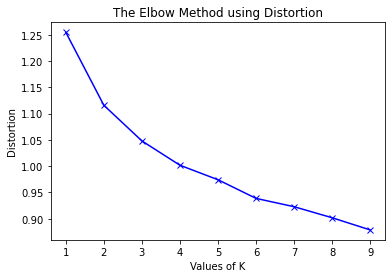

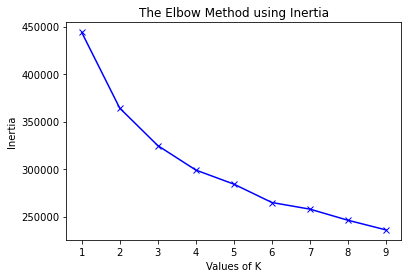

CPU times: user 12min 13s, sys: 10.3 s, total: 12min 23s
Wall time: 1min 49s


In [114]:
%%time
elbow(df)

# Preliminar clustering 
Clustering made on tfidf only in order to display some useful information about words classifications

In [115]:
# Is 4 the new optimal? [Choose optimal]
optimal = 4
kmeans = KMeans(n_clusters=optimal).fit(tf_idf)

# Make sense to clustering
Plot most common words from clusters

In [116]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

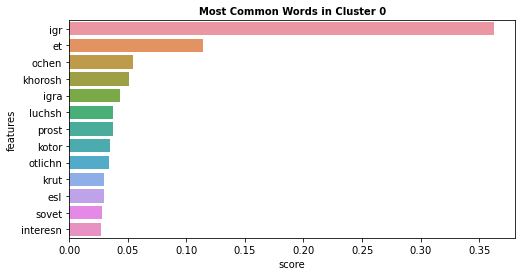

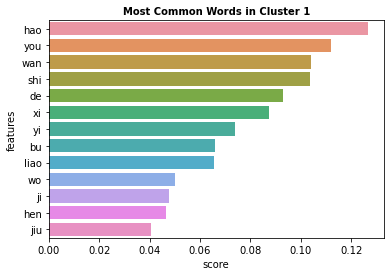

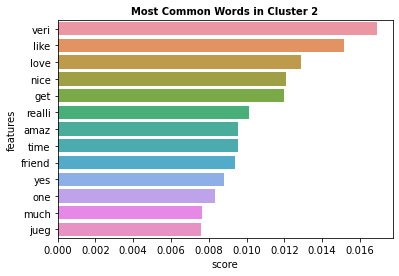

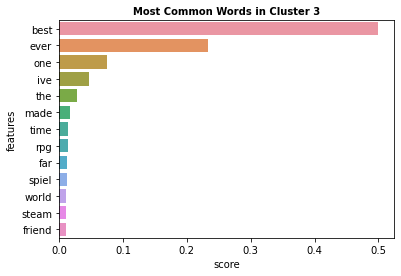

In [117]:
final_df_array = tf_idf.to_numpy()
prediction = kmeans.predict(tf_idf)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

# Word Cloud
Try to visualize some info about clusters

In [118]:
from wordcloud   import WordCloud

In [119]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

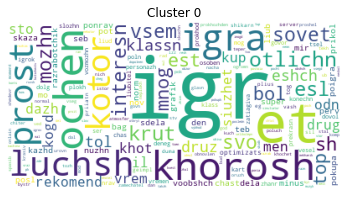

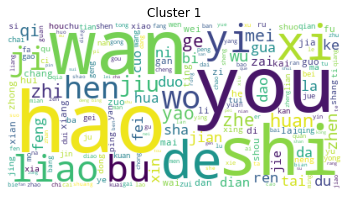

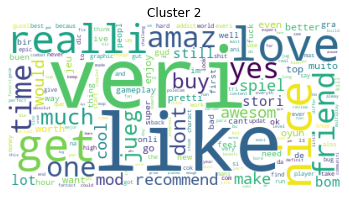

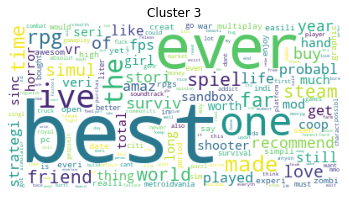

In [120]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = tf_idf.columns
generateWordClouds(centroids)

# Final K means
The optimal k means on the elaborated dataset

In [121]:
# Optimal k-means

kmeans = KMeans(n_clusters=optimal).fit(df)

labels = pd.DataFrame(kmeans.labels_) #This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeled_df = pd.concat((df,labels),axis=1)
labeled_df = labeled_df.rename({0:'labels'},axis=1)
labeled_df.head()

,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,...,pca_comp_247,pca_comp_248,pca_comp_249,pca_comp_250,pca_comp_251,pca_comp_252,pca_comp_253,pca_comp_254,pca_comp_255,labels
0,0.621007,-0.490334,0.505921,0.498464,-0.063435,0.042492,-0.233515,0.013696,-0.031920,0.031395,...,0.000302,0.000610,-0.021505,0.028660,0.004187,-0.000936,-0.000727,-0.009645,-0.012166,0
1,-0.486898,0.166921,-0.613946,0.573833,-0.355988,0.429233,-0.308200,0.002872,-0.032275,0.006128,...,0.000539,-0.023135,0.014730,-0.020073,-0.003915,-0.009586,-0.000535,-0.003888,0.003151,1
2,-0.810458,0.420791,0.520141,0.003343,0.267087,0.189527,-0.156110,-0.007000,-0.012378,0.008667,...,0.001137,0.003480,-0.004494,-0.001420,-0.000665,-0.020105,0.007925,-0.001467,-0.001822,2
3,-0.759772,0.367595,0.452603,-0.059521,0.274554,0.145222,-0.349082,-0.000594,-0.034040,0.034944,...,-0.008657,0.001765,-0.006751,-0.000073,-0.008215,-0.025199,0.009335,-0.002690,-0.002072,2
4,-0.365418,0.262527,-0.106185,0.408732,0.025201,-0.376808,-0.084632,-0.035379,0.073074,0.200087,...,0.000770,-0.002255,-0.000520,-0.001300,-0.001870,0.000974,-0.001843,-0.000129,-0.000912,1


# Final PCA
Computed only on two axis with previous copy of processed dataset, in order to plot data

In [122]:
pca_ =  PCA(n_components = 2)
pca_.fit(df_)
reduced = pca_.transform(df_)
print(reduced)

[[-0.62100644  0.49033305]
 [ 0.48689779 -0.16692027]
 [ 0.81045764 -0.42079102]
 ...
 [ 0.3175422  -0.13897357]
 [-0.6073316   0.59563754]
 [-0.59953396 -0.31561017]]


In [123]:
reduced_df = pd.DataFrame(data = reduced
             , columns = ['principal component 1', 'principal component 2'])
reduced_df.head()

,principal component 1,principal component 2
0,-0.621006,0.490333
1,0.486898,-0.166920
2,0.810458,-0.420791
3,0.759771,-0.367595
4,0.365418,-0.262526


In [124]:
print('Explained variation per principal component: {}'.format(pca_.explained_variance_ratio_))

Explained variation per principal component: [0.14635289 0.08602873]


In [125]:
labeled__df = pd.concat((reduced_df,labels),axis=1)
labeled__df = labeled__df.rename({0:'labels'},axis=1)
labeled__df.tail()

,principal component 1,principal component 2,labels
271486,0.286857,-0.161620,1
271487,-0.585842,-0.331707,3
271488,0.317542,-0.138974,1
271489,-0.607332,0.595638,0
271490,-0.599534,-0.315610,3


In [126]:
labeled__df['color'] = labeled__df.apply (lambda row:  'red' if row['labels'] == 1 else ('orange' if row['labels'] == 0 
                                                                                       else ('blue' if row['labels'] == 2 
                                                                                             else('green' if row['labels'] == 3 
                                                                                                  else ('brown' if row['labels'] == 4 else 'purple')))) , axis=1)

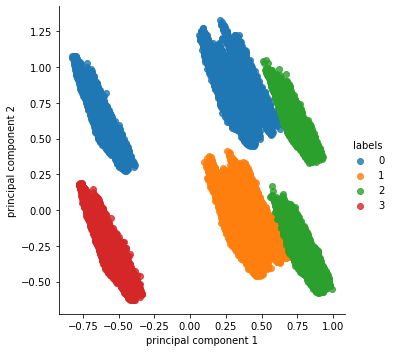

In [127]:
sns.lmplot(x='principal component 1',y='principal component 2',data=labeled__df,hue='labels',fit_reg=False)

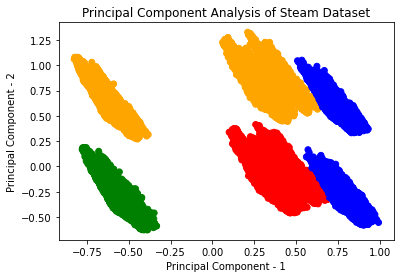

In [128]:
plt.xlabel('Principal Component - 1') 
plt.ylabel('Principal Component - 2') 
plt.title("Principal Component Analysis of Steam Dataset")

plt.scatter(labeled__df['principal component 1'] , labeled__df['principal component 2'], c = labeled__df['color']) 
plt.show()